# Semantic Segmentation with DeGirum's PySDK using Segmenter

Semantic segmentation is a difficult computer vision problem with many applications such as autonomous driving, robotics, augmented reality, and many others.
Its goal is to assign labels to each pixel according to the object it belongs to, creating so-called segmentation masks.
To properly assign this label, the model needs to consider the local as well as global context of the image.
This is where transformers offer their advantage as they work well in capturing global context.

Segmenter is based on Vision Transformer working as an encoder, and Mask Transformer working as a decoder.
With this configuration, it achieves good results on different datasets such as ADE20K, Pascal Context, and Cityscapes.
It works as shown in the diagram below, by taking the image, splitting it into patches, and then encoding these patches.
Mask transformer combines encoded patches with class masks and decodes them into a segmentation map as the output, where each pixel has a label assigned to it.

![Segmenter diagram](https://github.com/openvinotoolkit/openvino_notebooks/assets/93932510/f57979e7-fd3b-449f-bf01-afe0f965abbc)
> Credits for this image go to [original authors of Segmenter](https://github.com/rstrudel/segmenter).

More about the model and its details can be found in the following paper:
[Segmenter: Transformer for Semantic Segmentation](https://arxiv.org/abs/2105.05633) or in the [repository](https://github.com/rstrudel/segmenter).

The following notebook implements the execution of the Segmenter model in OpenVINO runtime using DeGirum's PySDK.

#### Table of contents:

- [Get and prepare PySDK model](#Get-and-prepare-PySDK-model)
    - [Prerequisites](#Prerequisites)
    - [Loading PySDK model](#Loading-PySDK-model)
- [Preparing preprocessing, inference support functions, and visualization functions](#Preparing-preprocessing-inference-support-functions-and-visualization-functions)
    - [Preprocessing](#Preprocessing)
    - [Inference Support](#Inference-Support)
    - [Inference Function](#Inference-Function)
    - [Visualization](#Visualization)
- [Inference of PySDK model](#Inference-of-PySDK-model)


To demonstrate how to use Segmenter with PySDK, this notebook consists of the following steps:

* Preparing PySDK Segmenter model
* Preparing preprocessing and visualization functions
* Running inference of the model

## Get and prepare PySDK model

### Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [6]:
!pip show degirum_tools || pip install degirum_tools

Name: degirum_tools
Version: 0.9.0
Summary: Tools for PySDK
Home-page: 
Author: DeGirum
Author-email: 
License: 
Location: /home/degirum/miniconda3/envs/esam/lib/python3.10/site-packages
Requires: degirum, ffmpegcv, ipython, numpy, opencv-python, pafy, pillow, psutil, pycocotools, python-dotenv, pyyaml, requests, scipy, youtube-dl
Required-by: 


In [7]:
import sys
from pathlib import Path

# clone Segmenter repo
if not Path("segmenter").exists():
    !git clone https://github.com/rstrudel/segmenter
else:
    print("Segmenter repo already cloned")

# include path to Segmenter repo to use its functions
sys.path.append("./segmenter")

Segmenter repo already cloned


In [8]:
%pip install -q "openvino>=2023.1.0"
%pip install -r segmenter/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Loading PySDK model

In [9]:
import degirum as dg

target = "@cloud"
cloud_zoo_url = "https://cs.degirum.com/degirum/openvino_demos"
cloud_token = "<your DeGirum Cloud token here>"

zoo = dg.connect(target, cloud_zoo_url, cloud_token)
model = zoo.load_model("segmenter--512x512_float_openvino_cpu_1")
model.input_image_format = "RAW"

## Preparing preprocessing, inference support functions, and visualization functions
[back to top ⬆️](#Table-of-contents:)

Now we will define utility functions for preprocessing, inferencing, and visualizing the results.

### Preprocessing
[back to top ⬆️](#Table-of-contents:)

Inference input is tensor with shape `[1, 3, H, W]` in `B, C, H, W` format, where:

* `B` - batch size (in our case 1, as we are just adding 1 with unsqueeze)
* `C` - image channels (in our case RGB - 3)
* `H` - image height
* `W` - image width

Splitting to batches is done inside inference, so we don't need to split the image in preprocessing.

Model expects images in RGB channels format, scaled to [0, 1] range and normalized with given mean and standard deviation.

In [10]:
# normalization parameters
normalization = {"mean": [0.5, 0.5, 0.5], "std": [0.5, 0.5, 0.5]}
# number of model classes
num_classes = 150
# window size
window_size = 512

In [11]:
from PIL import Image
import cv2
import numpy as np
from scipy.special import softmax
import math

def resize(im, smaller_size):
    """
    Resize image bilinearly to make shorter side at least as long as the dimension provided.
    """
    h, w = im.shape[2:]
    if h < w:
        ratio = w / h
        h_res, w_res = smaller_size, ratio * smaller_size
    else:
        ratio = h / w
        h_res, w_res = ratio * smaller_size, smaller_size
    if min(h, w) < smaller_size:
        im_res = cv2.resize(im, (int(h_res), int(w_res)), interpolation=cv2.INTER_LINEAR)
    else:
        im_res = im
    return im_res

def preprocess(im: Image, normalization: dict, window_size: int) -> np.ndarray:
    """
    Preprocess image: scale, normalize, unsqueeze, and resize

    :param im: input image
    :param normalization: dictionary containing normalization data
    :return:
            im: processed (scaled and normalized) image
    """
    # change PIL image to NumPy array and scale to [0, 1]
    im = np.asarray(im, dtype=np.float32) / 255.0
    # normalize by given mean and standard deviation
    im -= np.array(normalization["mean"])[None, None, :]
    im /= np.array(normalization["std"])[None, None, :]
    # HWC -> CHW
    im = np.transpose(im, (2, 0, 1))
    # change dim from [C, H, W] to [1, C, H, W]
    im = np.expand_dims(im, axis=0)
    # resize image to window size by shorter dimension
    im = resize(im, window_size)

    return im

### Inference Support
The functions below implement a sliding window methodology for model inference.

In [12]:
def sliding_window(im, flip, window_size, window_stride):
    """
    Create a batch of patches from the input image, based on provided window
    size and stride.
    """
    B, C, H, W = im.shape
    ws = window_size

    windows = {"crop": [], "anchors": []}
    h_anchors = np.arange(0, H, window_stride)
    w_anchors = np.arange(0, W, window_stride)
    h_anchors = [h for h in h_anchors if h < H - ws] + [H - ws]
    w_anchors = [w for w in w_anchors if w < W - ws] + [W - ws]
    for ha in h_anchors:
        for wa in w_anchors:
            window = im[:, :, ha : ha + ws, wa : wa + ws]
            windows["crop"].append(window)
            windows["anchors"].append((ha, wa))
    windows["flip"] = flip
    windows["shape"] = (H, W)
    return windows

def bilinear_interpolation(original_img, new_shape):
	"""
	Bilinear interpolation for masks in CHW format.
	"""
	#get dimensions of original image
	original_img = np.transpose(original_img, (1, 2, 0))
	old_h, old_w, c = original_img.shape
	new_h, new_w = new_shape
	#create an array of the desired shape. 
	#We will fill-in the values later.
	resized = np.zeros((new_h, new_w, c), dtype=original_img.dtype)
	#Calculate horizontal and vertical scaling factor
	w_scale_factor = old_w / new_w
	h_scale_factor = old_h / new_h
	for i in range(new_h):
		for j in range(new_w):
			#map the coordinates back to the original image
			x = i * h_scale_factor
			y = j * w_scale_factor
			#calculate the coordinate values for 4 surrounding pixels.
			x_floor = math.floor(x)
			x_ceil = min( old_h - 1, math.ceil(x))
			y_floor = math.floor(y)
			y_ceil = min(old_w - 1, math.ceil(y))

			if (x_ceil == x_floor) and (y_ceil == y_floor):
				q = original_img[int(x), int(y), :]
			elif (x_ceil == x_floor):
				q1 = original_img[int(x), int(y_floor), :]
				q2 = original_img[int(x), int(y_ceil), :]
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)
			elif (y_ceil == y_floor):
				q1 = original_img[int(x_floor), int(y), :]
				q2 = original_img[int(x_ceil), int(y), :]
				q = (q1 * (x_ceil - x)) + (q2	 * (x - x_floor))
			else:
				v1 = original_img[x_floor, y_floor, :]
				v2 = original_img[x_ceil, y_floor, :]
				v3 = original_img[x_floor, y_ceil, :]
				v4 = original_img[x_ceil, y_ceil, :]

				q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
				q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
				q = q1 * (y_ceil - y) + q2 * (y - y_floor)

			resized[i,j,:] = q
	resized = np.transpose(resized, (2, 0, 1))
	return resized

def merge_windows(windows, window_size, ori_shape):
    """
    Merge all inference result patches to create complete segmentation
    mask output of the model.
    """
    ws = window_size
    im_windows = windows["seg_maps"]
    anchors = windows["anchors"]
    C = im_windows[0].shape[0]
    H, W = windows["shape"]
    flip = windows["flip"]

    logit = np.zeros((C, H, W), dtype=np.float32)
    count = np.zeros((1, H, W), dtype=np.float32)
    for window, (ha, wa) in zip(im_windows, anchors):
        logit[:, ha : ha + ws, wa : wa + ws] += window
        count[:, ha : ha + ws, wa : wa + ws] += 1
    logit = logit / count
    logit = bilinear_interpolation(
        logit,
        ori_shape
    )
    if flip:
        logit = np.flip(logit, axis=2)
    result = softmax(logit, axis=0)
    return result

### Inference Function

The following code implements the main inference function, utilizing the inference support functions defined above to split the input image into patches, run the model inference on each path, and merge together all outputs.

In [13]:
def inference(
    model,
    num_classes,
    ims,
    ims_metas,
    ori_shape,
    window_size,
    window_stride,
    batch_size,
):
    C = num_classes
    seg_map = np.zeros((C, ori_shape[0], ori_shape[1]))
    for im, im_metas in zip(ims, ims_metas):
        flip = im_metas["flip"]
        windows = sliding_window(im, flip, window_size, window_stride)
        crops = np.stack(windows.pop("crop"))[:, 0]
        B = len(crops)
        WB = batch_size
        seg_maps = np.zeros((B, C, window_size, window_size))
        for i in range(0, B, WB):
            seg_maps[i : i + WB] = model(np.transpose(crops[i : i + WB], (0,2,3,1)).tobytes()).results[0]['data']
        windows["seg_maps"] = seg_maps
        im_seg_map = merge_windows(windows, window_size, ori_shape)
        seg_map += im_seg_map
    seg_map /= len(ims)
    return seg_map

### Visualization
[back to top ⬆️](#Table-of-contents:)

Inference output contains labels assigned to each pixel, so the output in our case is `[150, H, W]` in `CL, H, W` format where:

* `CL` - number of classes for labels (in our case 150)
* `H` - image height
* `W` - image width

Since we want to visualize this output, we reduce dimensions to `[1, H, W]` where we keep only class with the highest value as that is the predicted label.
We then combine original image with colors corresponding to the inferred labels.

In [14]:
import yaml

from segmenter.segm.data.utils import IGNORE_LABEL
from segmenter.segm.data.ade20k import ADE20K_CATS_PATH

def seg_to_rgb(seg, colors):
    im = np.zeros((seg.shape[0], seg.shape[1], seg.shape[2], 3), dtype=np.float32)
    cls = np.unique(seg)
    for cl in cls:
        color = colors[int(cl)]
        if len(color.shape) > 1:
            color = color[0]
        im[seg == cl] = color
    return im

def dataset_cat_description(path, cmap=None):
    desc = yaml.load(open(path, "r"), Loader=yaml.FullLoader)
    colors = {}
    names = []
    for i, cat in enumerate(desc):
        names.append(cat["name"])
        if "color" in cat:
            colors[cat["id"]] = np.array(cat["color"], dtype=np.float32) / 255.0
        else:
            colors[cat["id"]] = np.array(cmap[cat["id"]], dtype=np.float32)
    colors[IGNORE_LABEL] = np.array([0.0, 0.0, 0.0], dtype=np.float32)
    return names, colors

def apply_segmentation_mask(pil_im: Image, results: np.ndarray) -> Image:
    """
    Combine segmentation masks with the image

    :param pil_im: original input image
    :param results: tensor containing segmentation masks for each pixel
    :return:
            pil_blend: image with colored segmentation masks overlay
    """
    cat_names, cat_colors = dataset_cat_description(ADE20K_CATS_PATH)

    # 3D array, where each pixel has values for all classes, take index of max as label
    seg_map = np.argmax(results, axis=0, keepdims=True)
    # transform label id to colors
    seg_rgb = seg_to_rgb(seg_map, cat_colors)
    seg_rgb = (255 * seg_rgb).astype(np.uint8)
    pil_seg = Image.fromarray(seg_rgb[0])

    # overlay segmentation mask over original image
    pil_blend = Image.blend(pil_im, pil_seg, 0.5).convert("RGB")

    return pil_blend

## Validation of inference of PySDK model
[back to top ⬆️](#Table-of-contents:)

Now that we have everything ready, we can perform segmentation on example image `coco_hollywood.jpg`.

In [15]:
import cv2
import requests

def load_image(path: str) -> np.ndarray:
    """
    Loads an image from `path` and returns it as BGR numpy array. `path`
    should point to an image file, either a local filename or a url. The image is
    not stored to the filesystem. Use the `download_file` function to download and
    store an image.

    :param path: Local path name or URL to image.
    :return: image as BGR numpy array
    """

    if path.startswith("http"):
        # Set User-Agent to Mozilla because some websites block
        # requests with User-Agent Python
        response = requests.get(path, headers={"User-Agent": "Mozilla/5.0"})
        array = np.asarray(bytearray(response.content), dtype="uint8")
        image = cv2.imdecode(array, -1)  # Loads the image as BGR
    else:
        image = cv2.imread(path)
    return image

In [16]:
# load image with OpenCV
image = load_image("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_hollywood.jpg")
# load_image reads the image in BGR format, [:,:,::-1] reshape transfroms it to RGB
pil_image = Image.fromarray(image[:,:,::-1])

# preprocess image with normalization params loaded in previous steps
image = preprocess(pil_image, normalization, window_size)

# inference function needs some meta parameters, where we specify that we don't flip images in inference mode
im_meta = dict(flip=False)

In [17]:
# perform inference with same function as in case of PyTorch model from repository
results = inference(model=model,
                    num_classes=num_classes,
                    ims=[image],
                    ims_metas=[im_meta],
                    ori_shape=image.shape[2:4],
                    window_size=window_size,
                    window_stride=window_size,
                    batch_size=1)

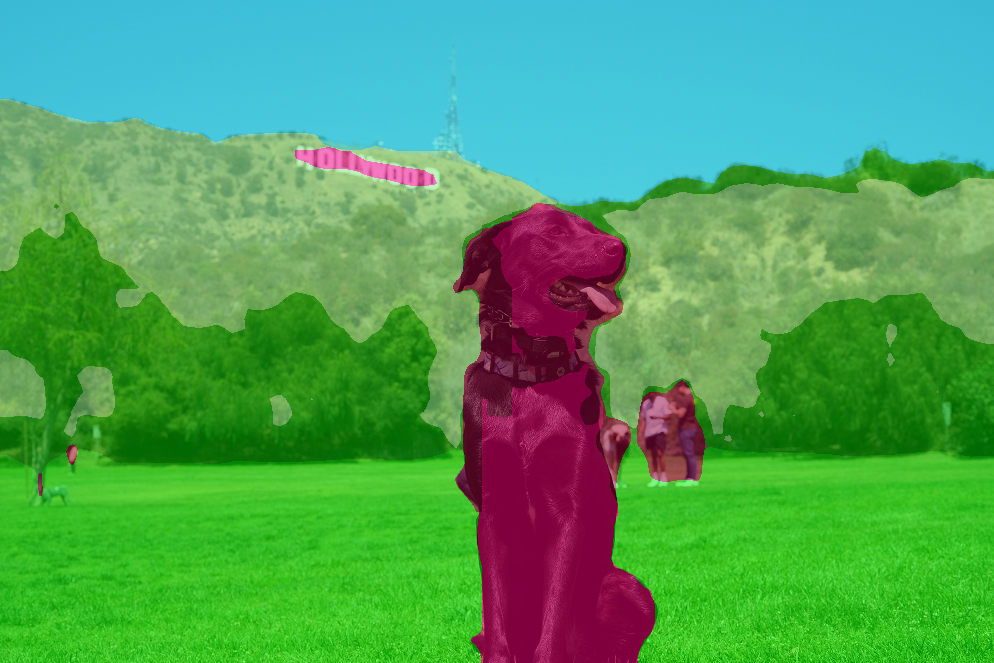

In [18]:
# combine segmentation mask with image
converted_blend = apply_segmentation_mask(pil_image, results)

# show image with segmentation mask overlay
converted_blend